In [1]:
#!pip install simple_fpa

In [2]:
%%capture out
! cd ..; pip install .

In [3]:
# print((out.stdout.split('\n')[-2]))

In [4]:
#print(plt.style.available)

In [5]:
import sys
sys.path.append('../simple_fpa')
from estimators import *

In [6]:
from simple_fpa import Model, load_haile
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import rcParams

plt.style.available
plt.style.use('seaborn-v0_8-white')

rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Arial"],
    "lines.linewidth": 1,
    "figure.dpi":200
})

rcParams['figure.figsize'] = 7, 2.5

In [7]:
data = load_haile()

In [8]:
model = Model(data = data, auctionid_columns = ['auctionid'], bid_column = 'actual_bid')
cont_covs = ['adv_value', 'hhi', 'volume_total_1']
disc_covs = ['year', 'forest']
model.residualize(cont_covs, disc_covs, 'multiplicative')

In [9]:
model.trim_residuals(5)
model.fit(smoothing_rate = 0.33, trim_percent = 5, boundary = 'reflect')
model.predict()

In [10]:
model.summary()

                            OLS Regression Results                            
Dep. Variable:     np.log(actual_bid)   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                 1.495e+04
Date:                Sat, 12 Oct 2024   Prob (F-statistic):               0.00
Time:                        17:57:38   Log-Likelihood:                -37633.
No. Observations:               60758   AIC:                         7.536e+04
Df Residuals:                   60711   BIC:                         7.578e+04
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  2

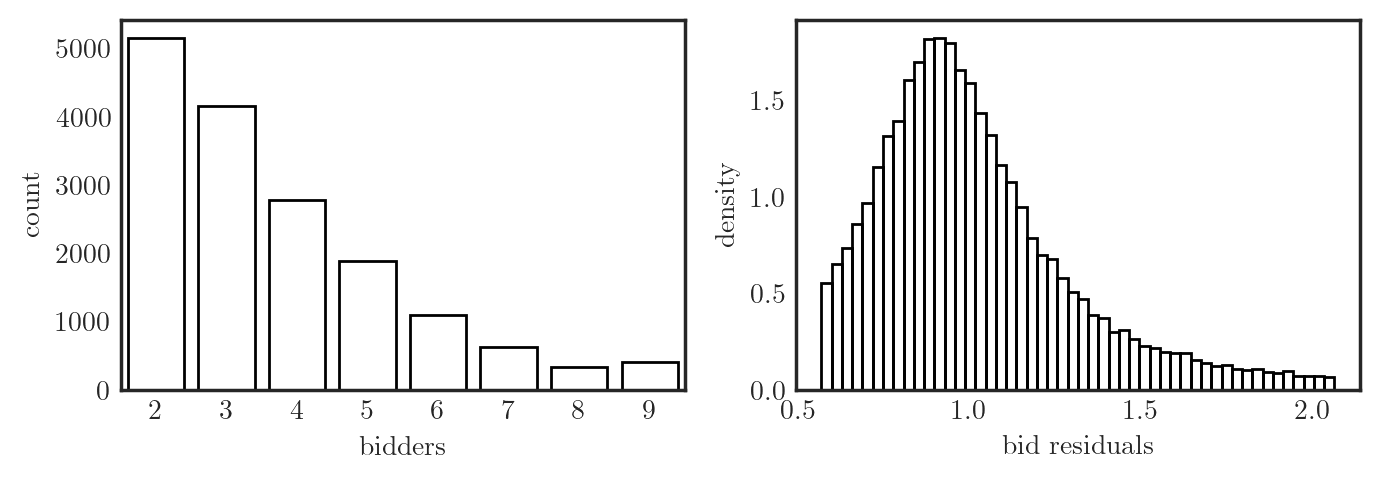

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2)
model.plot_bidders(ax1)
model.plot_bid_residuals(ax2)
plt.tight_layout()
plt.savefig('./bidders_and_bidresiduals.pdf')

In [12]:
confidence = 95
draws = 1000
model.make_ci_asy(95, hyp = 'twosided')

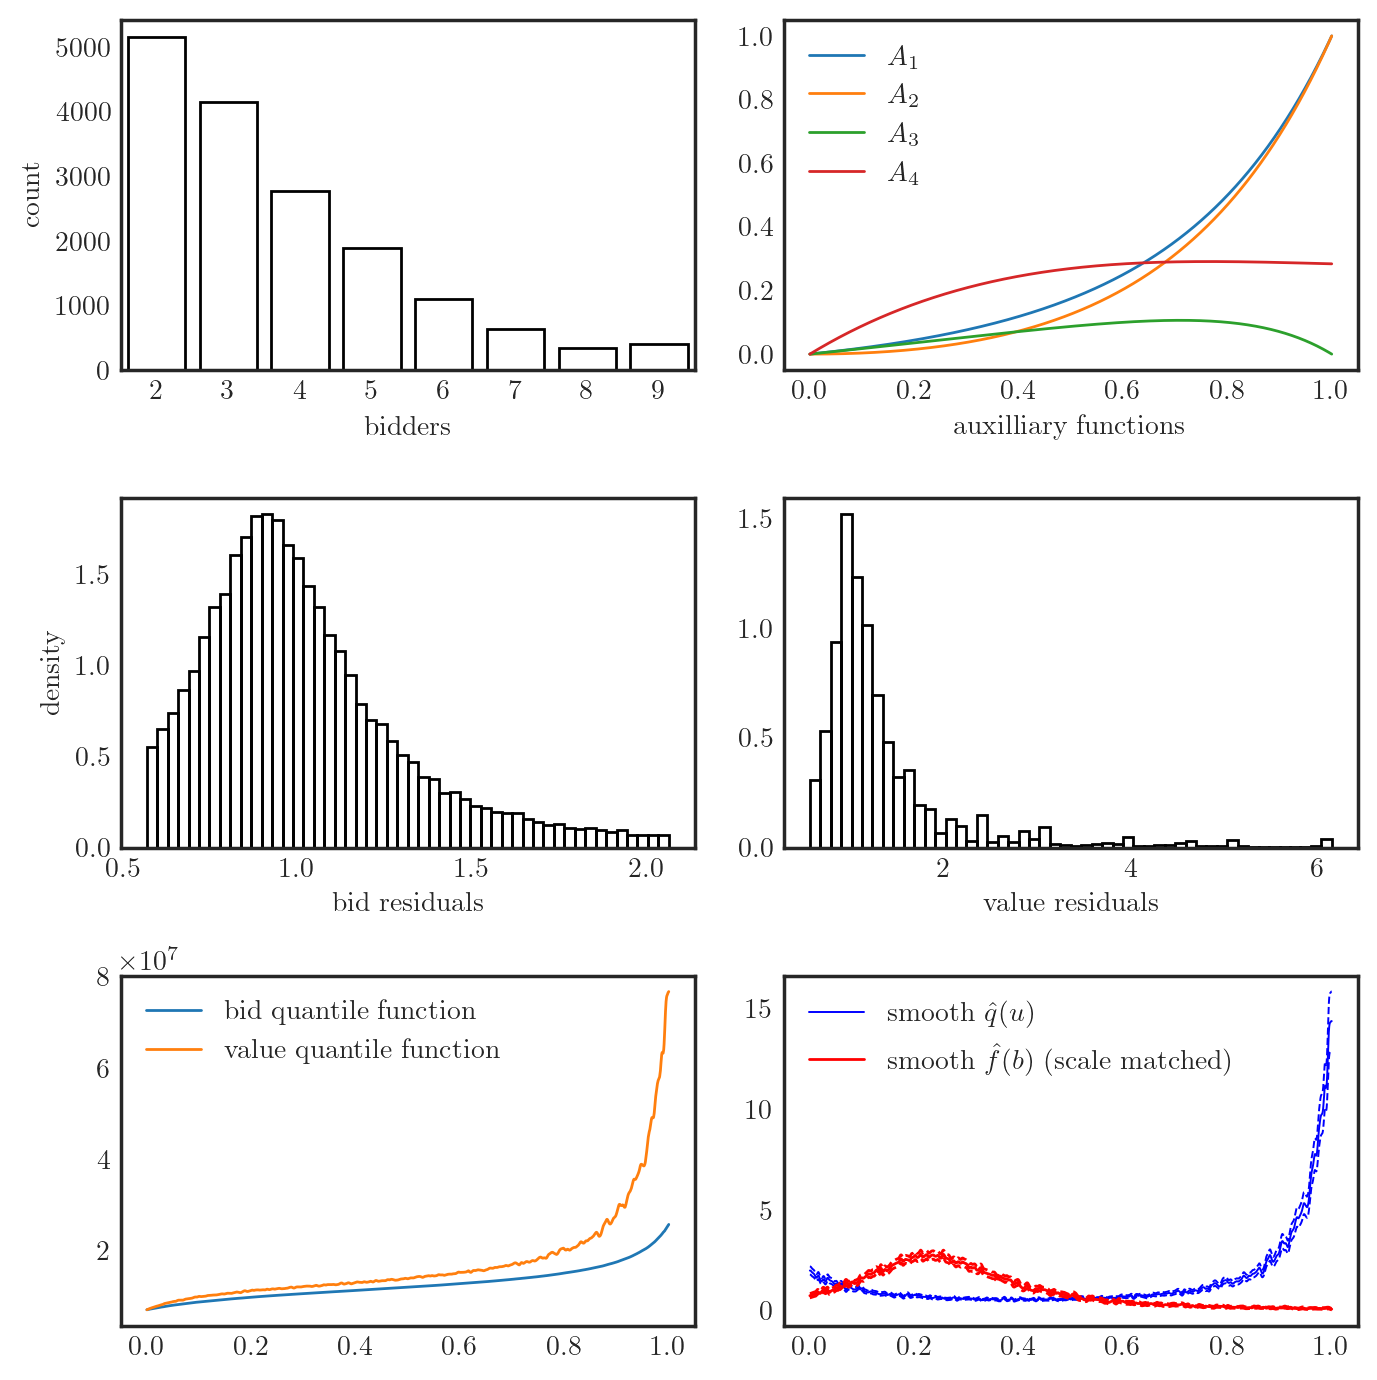

In [13]:
model.plot_stats()

In [14]:
model.make_cicb(95, draws = 1000, hyp = 'twosided')

optimal exclusion: 0.18729
expected fitted value: 12490213.54


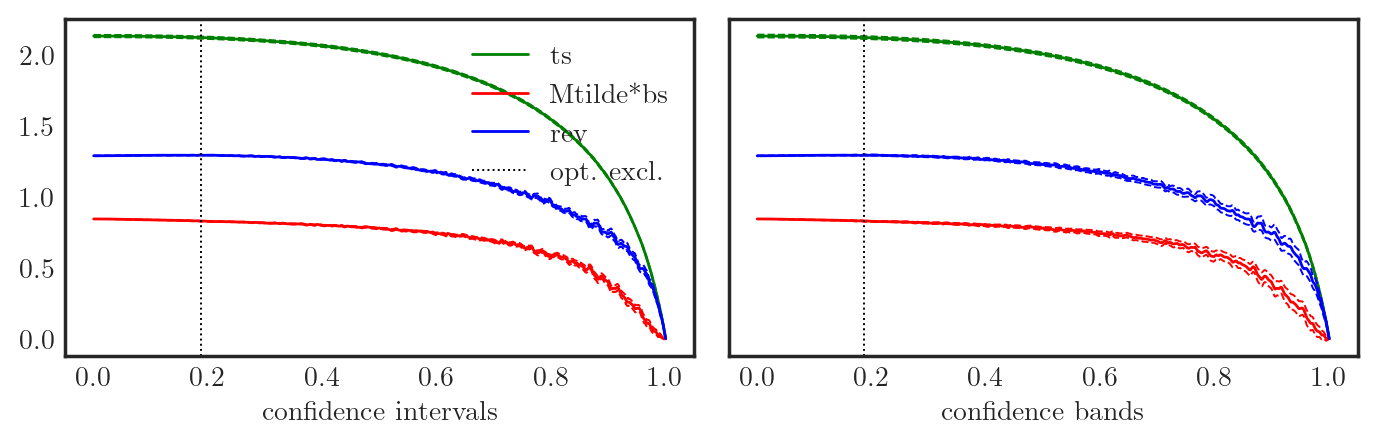

In [15]:
model.find_optimal_u()
model.find_expected_fitted()
model.plot_counterfactuals()

In [16]:
# various other stuff
# plt.plot(model.u_grid, model.ts, color = 'blue')
# plt.plot(model.u_grid, model.ts2, linestyle = '--', color = 'yellow')

# plt.plot(model.u_grid, model.rev, color = 'blue')
# plt.plot(model.u_grid, model.rev2, linestyle = '--', color = 'yellow')
# plt.plot(model.u_grid, model.rev_rea, linestyle = 'dotted', color = 'red')

# plt.xlim(model.u_trim, 1-model.u_trim)

In [17]:
# various other stuff
# fig, (ах1, ах2) = plt.subplots(1,2)

# ах1.plot(model.u_grid, model.ts, color = 'blue')
# ах1.plot(model.u_grid, model.ts2, linestyle = '--', color = 'yellow')
# ах1.set_xlim(model.u_trim, 1-model.u_trim)

# ах2.plot(model.u_grid, model.rev, color = 'blue')
# ах2.plot(model.u_grid, model.rev2, linestyle = '--', color = 'yellow')
# ах2.plot(model.u_grid, model.rev_rea, linestyle = 'dotted', color = 'red')

# #ах2.set_xlim(model.u_trim, 1-model.u_trim)

In [18]:
model.make_cicb(confidence, draws = draws, hyp = 'twosided')
rev_ci_two = model.data._rev_ci
rev_cb_two = model.data._rev_cb

model.make_cicb(confidence, draws = draws, hyp = 'onesided')
rev_ci_one = model.data._rev_ci
rev_cb_one = model.data._rev_cb

In [19]:
rev_ci_two.mean(), rev_ci_one.mean()

(0.00786154101375036, 0.00656041619109905)

In [20]:
rev_cb_two.mean(), rev_cb_one.mean()

(0.01624513915336606, 0.015574962463936708)

In [21]:
# lower_end_point = model.hat_v - model.rev_cb
# lower_end_point_rea = lower_end_point.copy()
# lower_end_point_rea[model.trim:-model.trim] = np.sort(lower_end_point_rea[model.trim:-model.trim])

In [22]:
# plt.plot(model.u_grid, lower_end_point_rea)
# plt.plot(model.u_grid, lower_end_point)

In [35]:
cutoff = .45
low = np.min((model.data._hat_rev - rev_cb_two)[:int(model.sample_size*cutoff)])
high = np.max(model.data._hat_rev + rev_cb_two)

In [36]:
model.expfit

12490213.537233533

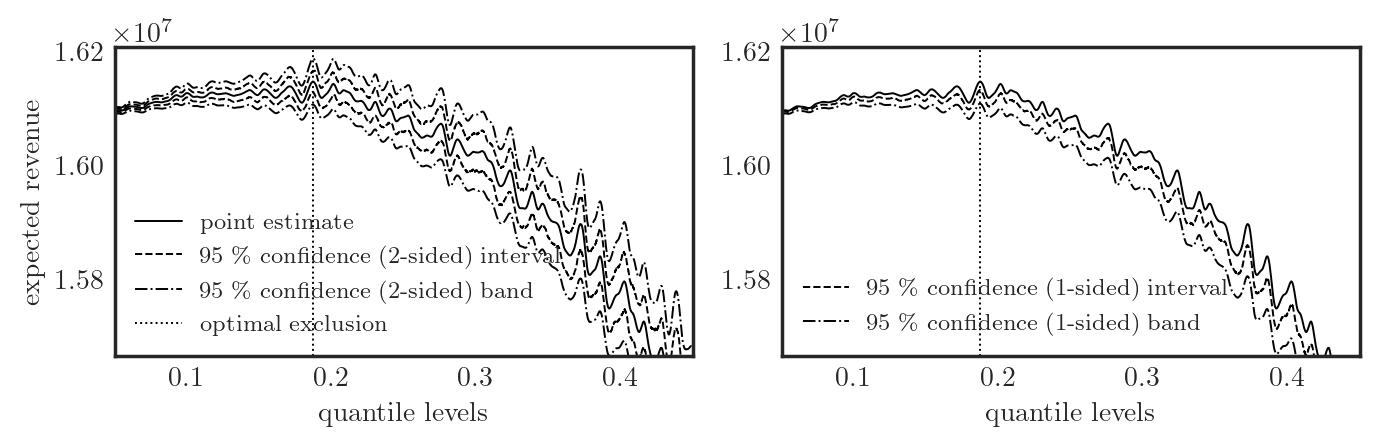

In [37]:
fig, (ax1, ax2) = plt.subplots(1,2)

lw = .7

ax1.plot(model.data._u, model.expfit*model.data._hat_rev, 
         label = 'point estimate', color = 'black', linewidth = lw)

ax1.plot(model.data._u, model.expfit*(-rev_ci_two + model.data._hat_rev), 
        color = 'black', linestyle = '--',linewidth = lw, 
         label = '95 \\% confidence (2-sided) interval')
ax1.plot(model.data._u, model.expfit*(rev_ci_two + model.data._hat_rev), 
        color = 'black', linestyle = '--',linewidth = lw)

ax1.plot(model.data._u, model.expfit*(-rev_cb_two + model.data._hat_rev), 
        color = 'black', linestyle = 'dashdot',linewidth = lw, 
         label = '95 \\% confidence (2-sided) band')
ax1.plot(model.data._u, model.expfit*(rev_cb_two + model.data._hat_rev), 
        color = 'black', linestyle = 'dashdot',linewidth = lw)

ax1.axvline(model.opt_u, linewidth = lw, color = 'black', 
            label = 'optimal exclusion', linestyle = 'dotted')
ax1.set_xlabel('quantile levels')
ax1.set_ylabel('expected revenue')

ax2.plot(model.data._u, model.expfit*(model.data._hat_rev), color = 'black', 
         linewidth = lw)

ax2.plot(model.data._u, model.expfit*(-rev_ci_one + model.data._hat_rev), 
        color = 'black', linestyle = '--',linewidth = lw, 
         label = '95 \\% confidence (1-sided) interval')

ax2.plot(model.data._u, model.expfit*(-rev_cb_one + model.data._hat_rev), 
        color = 'black', linestyle = 'dashdot',linewidth = lw, 
         label = '95 \\% confidence (1-sided) band')

ax2.axvline(model.opt_u, linewidth = lw, color = 'black', linestyle = 'dotted')
ax2.set_xlabel('quantile levels')
    
ax1.legend(fontsize = 'small', loc = 'lower left')
ax2.legend(fontsize = 'small', loc = 'lower left')
ax1.set_xlim(model.trim/model.sample_size, cutoff)
ax1.set_ylim(model.expfit*low,model.expfit*high + 20000)
ax2.set_xlim(model.trim/model.sample_size, cutoff)
ax2.set_ylim(model.expfit*low,model.expfit*high + 20000)

plt.tight_layout()
plt.savefig('./confidence_intervals_and_bands.pdf')